# Spatial and temporal completeness and uncertainties of carbon dioxide satellite observations for quantifying atmospheric greenhouse gas variability

Production date: 31-03-2025

Produced by: CNR

## 🌍 Use case: Using satellite observations for quantifying spatial and temporal variability in carbon dioxide concentrations

## ❓ Quality assessment question
* **Are the XCO$_2$ Level 3 data suitable for identifying regions characterized by high XCO$_2$ values?**
* **What are the uncertainties related to the XCO$_2$ satellite observations?**

Carbon dioxide (CO$_2$) is the most important anthropogenic greenhouse gas, accounting for nearly 64% of the total radiative forcing by long-lived greenhouse gases [[1]](https://library.wmo.int/viewer/68532/?offset=#page=4&viewer=picture&o=bookmarks&n=0&q=). The concentration of CO$_2$ in the atmosphere in 2023 was 420.0$\,\pm\,$0.1 ppm [[1]](https://library.wmo.int/viewer/68532/?offset=#page=4&viewer=picture&o=bookmarks&n=0&q=). Monitoring the long-term CO$_2$ variability is crucial for understanding the global carbon sources and sinks, improving [[2]](https://doi.org/10.5194/essd-17-965-2025) our knowledge of the carbon cycle, supporting the development of effective climate policies, and providing more reliable projections for future climate change.

In this assessment, we analyze the spatial variability of atmospheric column-averaged mixing ratios of CO$_2$ (XCO$_2$) over different regions using the Level 3 XCO$_2$ gridded data products (Obs4MIPs, version 4.5 [[3]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf)), whose main application is related to the comparison and validation of global climate models (e.g., [[4]](https://doi.org/10.5194/bg-17-6115-2020)). 

In particular, by comparison with an independent study based on a gap-free and fine-scale CO$_2$ dataset [[5]](https://doi.org/10.1016/j.envint.2023.108057), we assess the ability of this dataset to reproduce temporal and spatial anomalies in XCO$_2$, also quantifying the uncertainty provided with the dataset.

The code is included for transparency and to allow users to adapt it to their needs.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The XCO$_2$ satellite observations (Level 3, Obs4MIPs, version 4.5) provide a  consistent global description of the spatial XCO$_2$ pattern and can be used to detect areas characterized by elevated XCO$_2$ values. Care should be excercised when considering data from regions affected by high uncertainties. The highest uncertainty values were found over high latitudes, the Himalayas and the tropical rainforest zone due to the occurrence of large solar zenith angles or frequent cloud cover. 
* As data availability and uncertainty are not constant over space and time, users are advised to consider the evolution of their values over the spatial regions and time periods of interest. 
* Users must be aware that the 5$^\circ$x5$^\circ$ averaging can introduce a smoothing effect in the spatial XCO$_2$ field with respect to the Level 2 datasets.
* The main use of this data product is for comparison with climate models. Users interested in investigating the CO$_2$ fluxes occurring at the Earth's surface are advised to use products specifically designed for this purpose.
```

## 📋 Methodology

This notebook aims to provide users with information on the availability of XCO$_2$ Level 3 products, both globally and for specific user-defined regions. Additionally, it offers insights into the uncertainties associated with XCO$_2$ measurements and how these variables vary over time.

More specifically, this notebook aims to:
* Produce global maps of yearly XCO$_2$ anomalies for comparison with an external dataset [[5]](https://doi.org/10.1016/j.envint.2023.108057).
* Generate global maps for the corresponding XCO$_2$ uncertainty ("xco2_stderr").
* Produce maps of XCO$_2$ for specific regions over land [[5]](https://doi.org/10.1016/j.envint.2023.108057).
* Create time series of selected XCO$_2$ variables ("xco2", "xco2_stderr" and "xco2_nobs"), for specific regions. Please note that this analysis can be customized by the user to include one additional variable (not shown here): "xco2_stddev", which represents the standard deviation of the XCO$_2$ Level 2 observations within each grid box.
  
The analysis and results are organized in the following steps, which are detailed in the sections below:

**[](template:section-1)**
 * Import all relevant packages.
 * Define the temporal and spatial coverage, land mask, and spatial regions for the analysis.
 * Cache needed functions.

**[](template:section-2)**
 * Define the data request to CDS.
 * Define the data request for the external dataset. 

**[](template:section-3)**
 
 This section presents several results for the XCO$_2$ products, i.e.:
 * Annual global maps of the XCO$_2$ anomalies for 2015-2020 and comparison between CDS and the external dataset
 * Annual global maps of the XCO$_2$ uncertainties for 2015-2020
 * A focus of the XCO$_2$ maps over specific regions, and considering a single month (January 2016)
 * Global and regional time series of XCO$_2$, related uncertainties and data availability over the entire data period (2003-2022)

## 📈 Analysis and results

(template:section-1)=
### 1. Choose the data to use and set-up the code

#### Import all relevant packages
In this section, we import all the relevant packages needed for running the notebook.

In [1]:
import math
import pathlib

import cacholote
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import pooch
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-paper")

download.INVALIDATE_CACHE = False #Set True to invalidate the caching

#### Define temporal and spatial coverage, land mask, and spatial regions for the analysis
In this section, we define the parameters to be ingested by the code (that can be customized by the user), i.e.: 
* the temporal period of analysis;
* the activation/deactivation of the land masking;
* the regions of interest;
* the link to the external dataset.

In [2]:
# Single time to display
time = "2016-01"

# Range for 2015-2020
time_range = slice("2015", "2020")

# Mask
min_land_fraction = 0.5  # Use None to switch off

# Regions
regions = {
    "global": {"lon_slice": slice(-180, 180), "lat_slice": slice(-90, 90)},
    "north_america": {"lon_slice": slice(-160, -60), "lat_slice": slice(10, 90)},
    "europe_africa": {"lon_slice": slice(-20, 80), "lat_slice": slice(-5, 60)},
    "east_asia": {"lon_slice": slice(70, 165), "lat_slice": slice(-15, 80)},
}

# External data
zhang_url = "https://zenodo.org/records/7721945/files/XCO2.zip?download=1"

#### Cache needed functions
In this section, we cached a list of functions used in the analyses.

* The `convert_units` function rescales XCO$_2$ mole fraction (and related variables, except "xco2_nobs") to parts per million (ppm).

* The `mask_scale_and_regionalise` function extracts the XCO$_2$ data over the selected spatial region. It uses spatial weighting to account for the latitudinal dependence of the grid size in the lon/lat grids used for the reanalysis and for the forecast models. It uses the `convert_units` function for rescaling the values to ppm, and it applies the threshold (if any) on the minimum land fraction.

In [3]:
def convert_units(da):
    if da.name.endswith("_nobs"):
        return da

    with xr.set_options(keep_attrs=True):
        if da.name.startswith("xch4") and da.attrs["units"] != "ppb":
            da = da * 1.0e9
            da.attrs["units"] = "ppb"
        elif da.name.startswith("xco2") and da.attrs["units"] != "ppm":
            da = da * 1.0e6
            da.attrs["units"] = "ppm"
    return da


def mask_scale_and_regionalise(ds, min_land_fraction, lon_slice, lat_slice):
    if min_land_fraction is not None:
        ds = ds.where(ds["land_fraction"] >= min_land_fraction)
    for var, da in ds.data_vars.items():
        if (fill_value := da.attrs.pop("fill_value", None)) is not None:
            da = da.where(da != fill_value.astype(da.dtype))
        ds[var] = convert_units(da)
    return utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)

(template:section-2)=
### 2. Retrieve data

#### 2.1 Obs4MIPs
In this section, we define the data request to CDS (data product Obs4MIPs, Level 3, version 4.5, XCO$_2$) and download the datasets (i.e., the 2015-2020 period, and the whole dataset).

In [4]:
collection_id = "satellite-carbon-dioxide"
request = {
    "processing_level": ["level_3"],
    "variable": "xco2",
    "sensor_and_algorithm": "merged_obs4mips",
    "version": ["4_5"],
}

In [5]:
# Retrieve the 2015-2020 dataset
datasets = {}
for region, kwargs in regions.items():
    print(f"{region=}")
    ds = download.download_and_transform(
        collection_id,
        request,
        transform_func=mask_scale_and_regionalise,
        transform_func_kwargs={"min_land_fraction": min_land_fraction} | kwargs,
    ).sel(time=time_range)
    for da in ds.data_vars.values():
        if da.attrs.get("units") in ["1", 1]:
            da.attrs.pop("units")
    datasets[region] = ds

# Retrieve the whole dataset, for plotting the time series
datasets_ts = {}
for region, kwargs in regions.items():
    print(f"{region=}")
    ds = download.download_and_transform(
        collection_id,
        request,
        transform_func=mask_scale_and_regionalise,
        transform_func_kwargs={"min_land_fraction": min_land_fraction} | kwargs,
    )
    for da in ds.data_vars.values():
        if da.attrs.get("units") in ["1", 1]:
            da.attrs.pop("units")
    datasets_ts[region] = ds


region='global'


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


region='north_america'


100%|██████████| 1/1 [00:00<00:00, 36.98it/s]


region='europe_africa'


100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


region='east_asia'


100%|██████████| 1/1 [00:00<00:00, 34.96it/s]


region='global'


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

region='north_america'



100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


region='europe_africa'


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


region='east_asia'


100%|██████████| 1/1 [00:00<00:00, 31.13it/s]


#### 2.2 Zhang et al. (2023) dataset
In this section, we define the data request to the external dataset used for the comparison excercise.

In [6]:
def preprocess(ds):
    ds = ds.squeeze(drop=True)
    ds = ds.rename(x="longitude", y="latitude").rename(band_data="xco2")
    start = pd.to_datetime(pathlib.Path(ds.encoding["source"]).stem, format="%Y%m")
    end = start + pd.offsets.MonthEnd(1)
    middle = start + (end - start) / 2 + pd.Timedelta(hours=12)
    ds = ds.expand_dims(time=[middle])
    for dim in ds.dims:
        ds[dim].attrs["standard_name"] = dim
    return ds


@cacholote.cacheable
def get_zhang_et_al(url, known_hash="md5:22b4ac997247df9104fefefb3444926a"):
    fnames = pooch.retrieve(
        url=url,
        known_hash=known_hash,
        processor=pooch.Unzip(),
    )
    ds = xr.open_mfdataset(fnames, preprocess=preprocess)
    (da,) = ds.data_vars.values()
    da = da.coarsen(longitude=50, latitude=50).mean()
    for coord in ["longitude", "latitude"]:
        da[coord] = da[coord].round(1)
    return da.to_dataset(name="xco2")


ds = get_zhang_et_al(zhang_url).sel(time=time_range)
zhang_datasets = {}
for region, kwargs in regions.items():
    print(f"{region=}")
    zhang_datasets[region] = utils.regionalise(ds, **kwargs)

region='global'
region='north_america'
region='europe_africa'
region='east_asia'


(template:section-3)=
### 3. Data analysis for the different variables

#### Global maps of XCO$_2$ anomalies
In this section, global maps of XCO$_2$ anomalies for the years 2015–2020 are presented. The calculation of anomalies is achieved by the subtraction of the annual global average from the global XCO$_2$ concentrations, in accordance with the approach outlined in [[5]](https://doi.org/10.1016/j.envint.2023.108057). Prior to the execution of the calculations, a land mask was implemented. A comparison was made between the XCO$_2$ anomalies from the Obs4MIPs (version 4.5) dataset and the results from the gap-free and fine-scale XCO$_2$ dataset created by [[5]](https://doi.org/10.1016/j.envint.2023.108057). Prior to the comparison, the external dataset was regridded to a 5° x 5° regular grid by means of an arithmetic unweighted averaging process.
Throughout all the considered years, regions within the 10$^\circ\,$S–40$^\circ\,$N latitude band exhibit positive XCO$_2$ anomalies, consistent with the dataset produced by [[5]](https://doi.org/10.1016/j.envint.2023.108057). Both datasets reported similar features in the interannual variability of XCO$_2$ anomalies, like the higher values over China in 2020 compared to 2019, positive anomalies over Southeast Asia in 2016, and over tropical Africa in 2016, 2017 and 2018.
Focusing on the yearly bias (obtained by subtracting the Zhang et al. [[5]](https://doi.org/10.1016/j.envint.2023.108057) anomalies from the Obs4MIPs anomalies), the absolute differences in the yearly anomalies were mostly related to the high latitudes and the tropical regions. Moreover, the dataset [[5]](https://doi.org/10.1016/j.envint.2023.108057) appears to provide a smoother spatial field of XCO$_2$ anomalies with respect to Obs4MIPs (version 4.5), probably due to the use of a learning machine algorithm to produce this gap filled dataset.
Please note that the horizontal coverage of the XCO2_OBS4MIPS dataset (version 4.5) extends approximately from 60$^\circ\,$S to 70$^\circ\,$N [[6]](https://amt.copernicus.org/articles/13/789/2020/). During the investigated period, the external dataset [[5]](https://doi.org/10.1016/j.envint.2023.108057) provided XCO$_2$ also for Greenland, a region over which Obs4MIPs (version 4.5) did not provide data. This is due to the high surface albedo, which hinders the reliability of satellite retrievals, even during periods of illumination.

/data/wp5/.tmp/ipykernel_1242989/2289540217.py:27: FutureWarning: updating coordinate 'panel' with a PandasMultiIndex would leave the multi-index level coordinates ['year', 'product'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['panel', 'year', 'product'])` before assigning new coordinate values.
  da_all = da_all.assign_coords(panel=("panel", panel_labels))


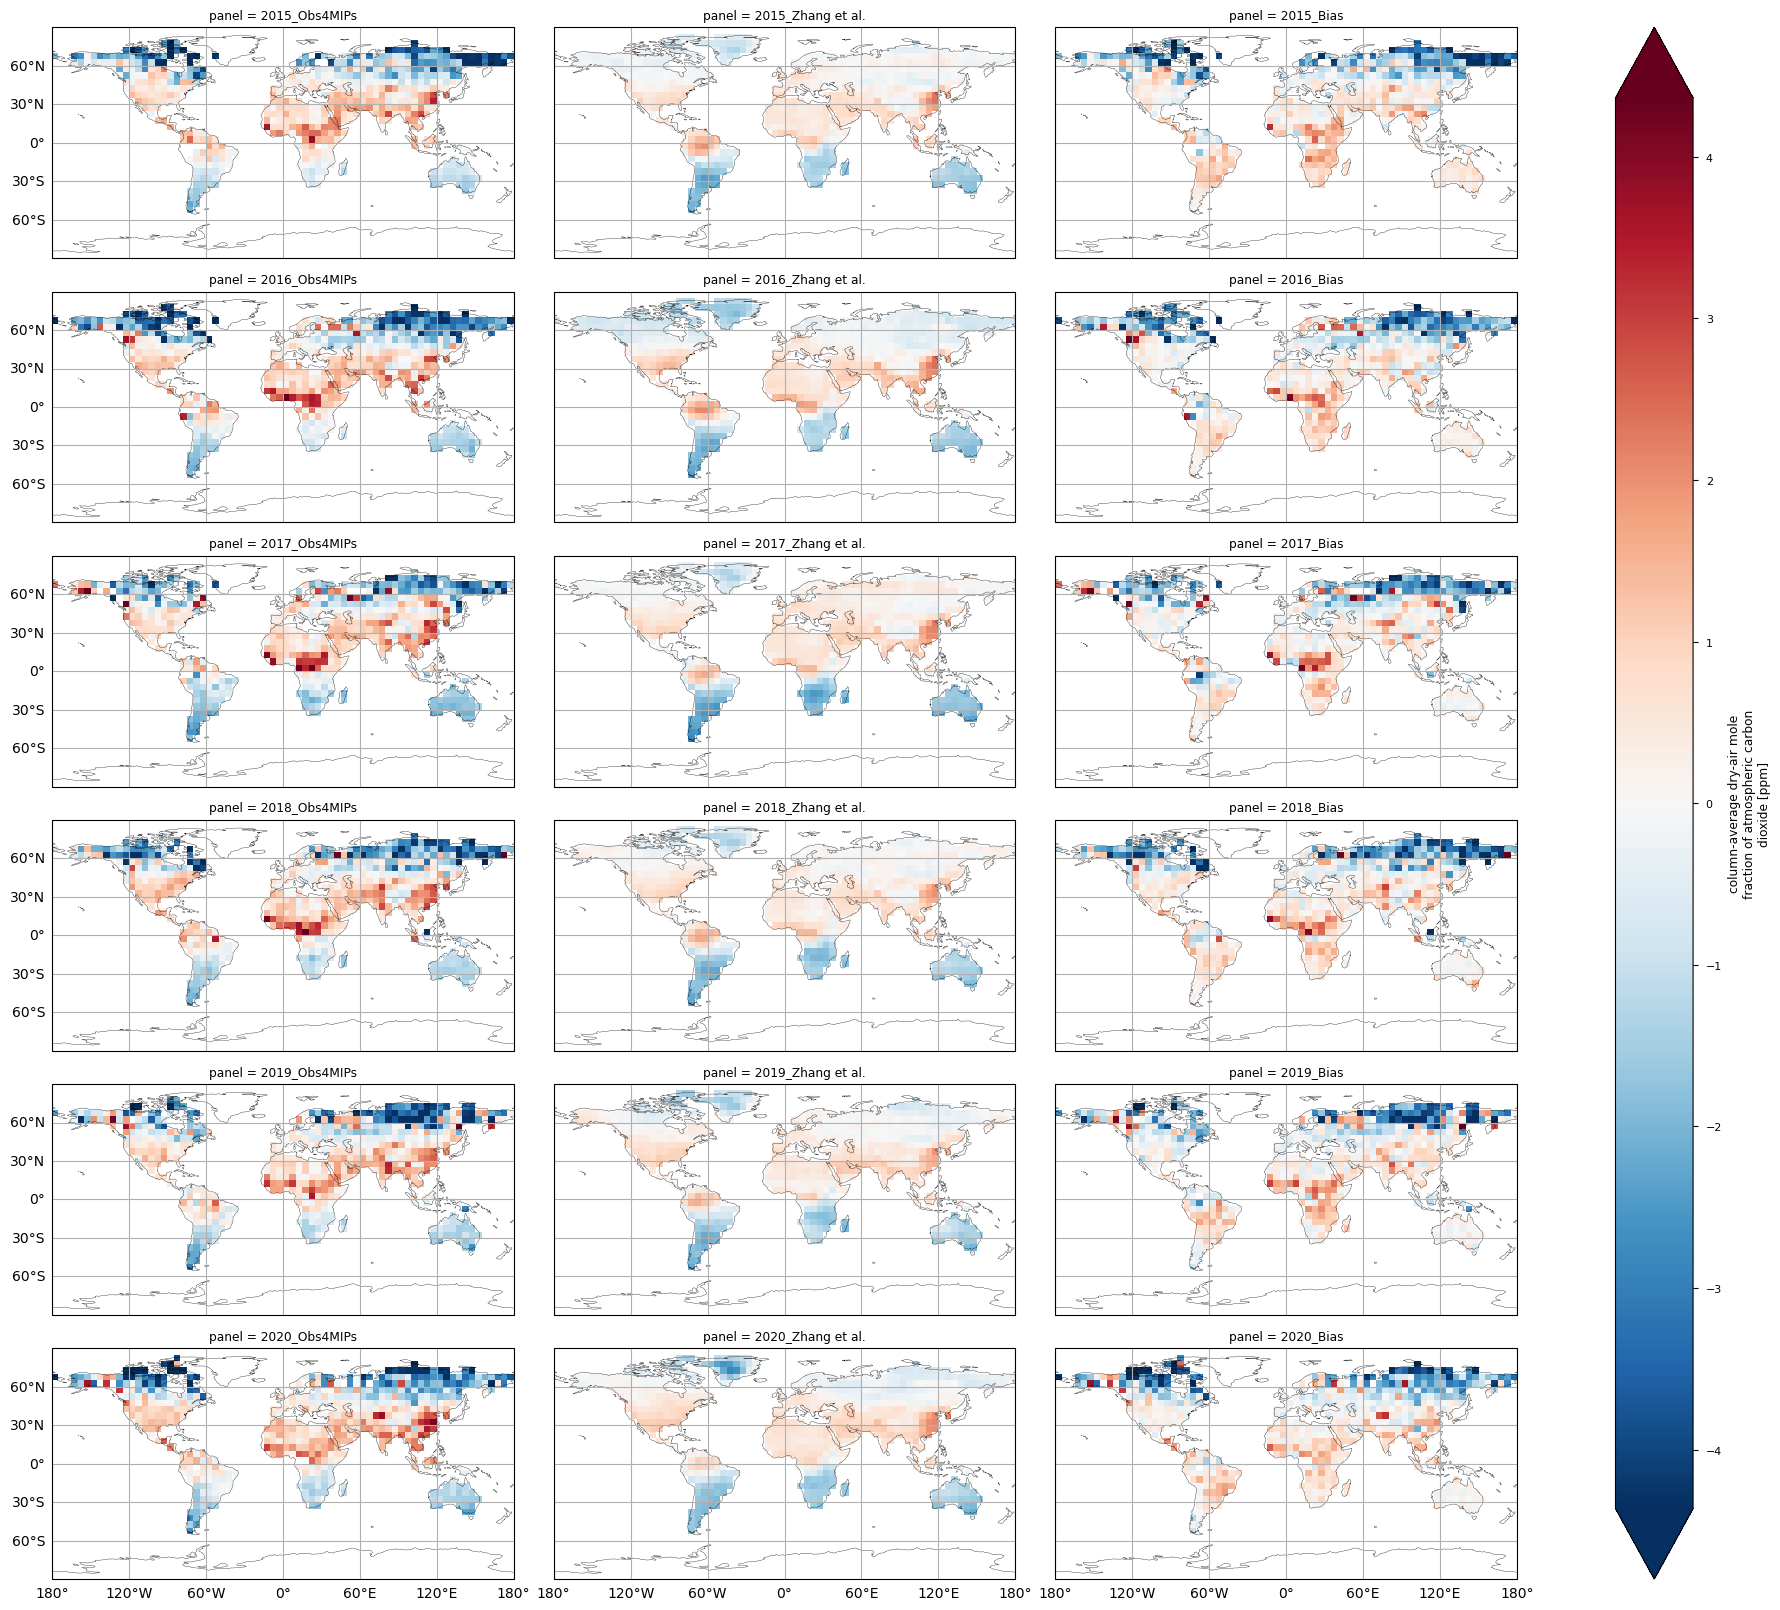

In [7]:
variable = "xco2"
for region in ["global"]:
    da = xr.concat(
        [
            datasets[region][variable].expand_dims(product=["Obs4MIPs"]),
            zhang_datasets[region][variable].expand_dims(product=["Zhang et al."]),
        ],
        "product",
    )
    if min_land_fraction:
        da = da.where(datasets[region]["land_fraction"] >= min_land_fraction)
    da = diagnostics.annual_weighted_mean(da)
    da_year = diagnostics.spatial_weighted_mean(da)
    with xr.set_options(keep_attrs=True):
        da = da - da_year
        bias = da.sel(product="Obs4MIPs") - da.sel(product="Zhang et al.")
        bias = bias.expand_dims(product=["Bias"])
   
    # Unisci tutti e 3 i set
    da_all = xr.concat([da, bias], dim="product")

    # Stack delle dimensioni (year, product) in "panel"
    da_all = da_all.stack(panel=("year", "product"))

    # Assegna etichette leggibili ai pannelli
    panel_labels = [f"{y}_{p}" for y, p in da_all.panel.values]
    da_all = da_all.assign_coords(panel=("panel", panel_labels))

    facet = plot.projected_map(
        da_all, col="panel", col_wrap=3, figsize=(20, 16), robust=True)
    plt.show()

*The figure shows the multi-year global distribution of XCO$_2$ anomalies (from 2015 to 2020) derived from the XCO2_OBS4MIPS dataset (version 4.5) as well as for the gap-filled dataset produced by Zhang et al. (2023) and the bias (Obs4MIPs - Zhang et al.) between the two datasets.*

#### Global maps of XCO$_2$ uncertainties
In this section, we show the multi-year global maps of the XCO$_2$ reported uncertainties, i.e., the "xco2_stderr" variable. This parameter is defined as the standard error of the average including single sounding noise and potential seasonal and regional biases [[3]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf). The yearly averages are calculated by averaging the monthly values provided by the considered dataset. Throughout all the considered years some features emerge, with higher uncertainties over high latitudes, the Himalayas, and the tropical rainforest zone, which are the regions where we observed larger deviations between Obs4MIPs (version 4.5) and the external dataset [[5]](https://doi.org/10.1016/j.envint.2023.108057). This is mainly due to the sparseness in sampling because of frequent cloud cover, as well as large solar zenith angles in high latitudes, which is a challenge for accurate XCO$_2$ retrievals [[6]](https://amt.copernicus.org/articles/13/789/2020/).

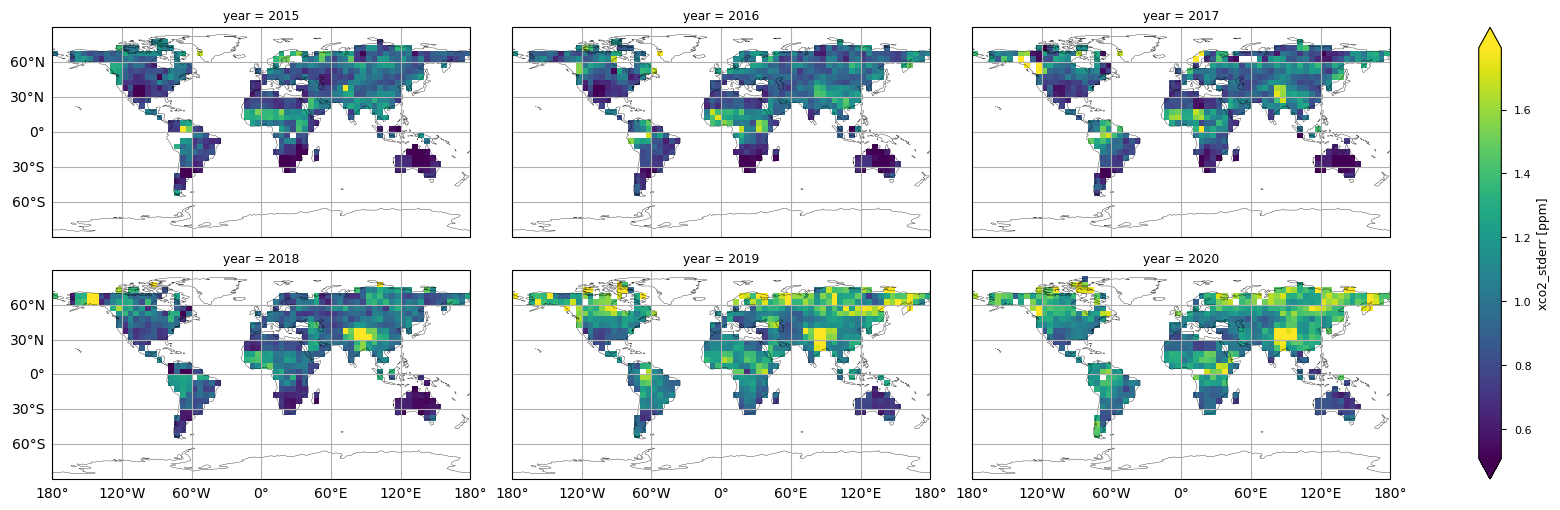

In [8]:
for region in ["global"]:
    ds = datasets[region]
    for variable in ["xco2_stderr"]:
        da = diagnostics.annual_weighted_mean(ds[variable])
        facet = plot.projected_map(da, col="year", col_wrap=3, figsize=(18, 5), robust=True)

*The figure shows the multi-year global distribution of XCO$_2$ standard error (from 2015 to 2020), derived from the XCO2_OBS4MIPS dataset (version 4.5).*

#### Regional maps of XCO$_2$
In this section, we show the maps of the XCO$_2$ values for January 2016, both globally and over specific regions. The selected regions (i.e., North America, Europe/Africa, and East Asia) were chosen according to [[5]](https://doi.org/10.1016/j.envint.2023.108057). A direct comparison for January 2015 was not possible, as the Level 3 XCO$_2$ data are missing for that month in the XCO2_OBS4MIPS dataset (version 4.5). The XCO$_2$ patterns are similar and comparable, especially for Europe/Africa and East Asia. However, the Level 3 data cover lesser areas than the product in [[5]](https://doi.org/10.1016/j.envint.2023.108057), with missing data especially at latitudes above 50$^\circ\,$N. 

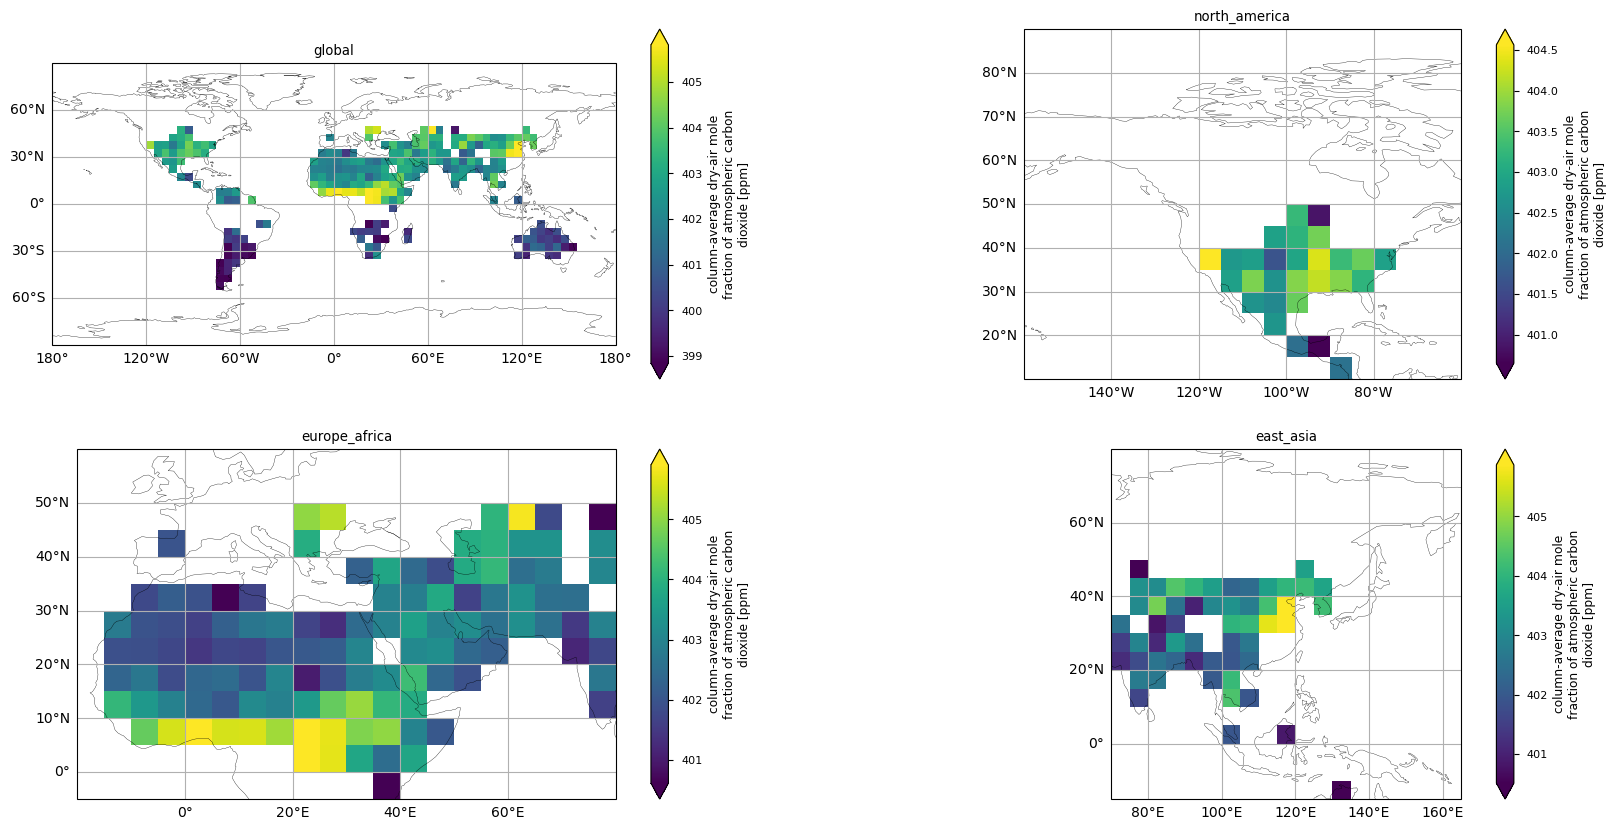

In [9]:
for variable in ["xco2"]:
    fig, axs = plt.subplots(
        2,
        math.ceil(len(regions) / 2),
        subplot_kw={"projection": ccrs.PlateCarree()},
        figsize=(20, 10),
    )
    for ax, (region, ds) in zip(axs.flatten(), datasets.items()):
        da = ds[variable].sel(time=time)
        plot.projected_map(da, ax=ax, show_stats=False, robust=True)
        ax.set_title(region)
    #fig.suptitle(f"{variable =} {time = }")
    plt.show()

*The figure shows the spatial distribution of XCO$_2$ values over the globe and selected regions, derived from the XCO2_OBS4MIPS dataset (version 4.5), for January 2016.*

#### Time series analysis for the different variables
In this section, we show the time series for two XCO$_2$ variables (i.e., "xco2" and "xco2_stderr"), considering both the entire dataset and specific regions of interest. For each variable, each plot displays the monthly spatial average for each region, along with the corresponding monthly standard deviation.
This analysis would provide the user with:
* the time series of XCO$_2$ values ("xco2") for each region, highlighting the positive trends;
* the regional change over time of the uncertainties associated to the XCO$_2$ values ("xco2_stderr").
* the time series of "xco2_nobs", which denotes the number of individual XCO$_2$ Level 2 observations used to compute the monthly Level 3 data.

In particular, an increase in the uncertainties ("xco2_stderr") is observed after 2009, likely due to the increase in the number of algorithms used to calculate the median XCO$_2$ data [[7]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_D_latest.pdf). A further increase in the uncertainties is observed from 2020 onwards, and this is probably linked to both the increase in the number of algorithms and the change in the minimum number of algorithms required to calculate the median XCO$_2$ [[7]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_D_latest.pdf). In addition, regions with more difficult retrieval conditions due to frequent cloud cover (e.g., East Asia) show larger uncertainties due to larger inter-algorithm spreads [[6]](https://amt.copernicus.org/articles/13/789/2020/).

The temporal variability of "xco2_nobs" traces the changes over time of the input data availability, and the number of used algorithms to obtain the merged Level 2 data products (XCO2_EMMA), from which the Obs4MIPs data product is derived (please note that the standard deviations have not been reported for "xco2_nobs" in order to increase the plot's readability.).
The first time period (up to April 2009) is characterised by a significant number of soundings by the SCIAMACHY sensor. The subsequent period (2009-September 2014) reflects the reduced number of single soundings provided by SCIAMACHY with the contribution from GOSAT. The following period, which extends up to 2019, reflects the contributions from both GOSAT and OCO-2. In contrast, the final period of the dataset reflects the contributions from GOSAT, OCO-2, and GOSAT-2. A comprehensive analysis of the number of soundings contained within the EMMA database on a monthly basis, along with the comparative contribution of each individual Level 2 algorithm to the EMMA database, can be found in [[7]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_D_latest.pdf). 

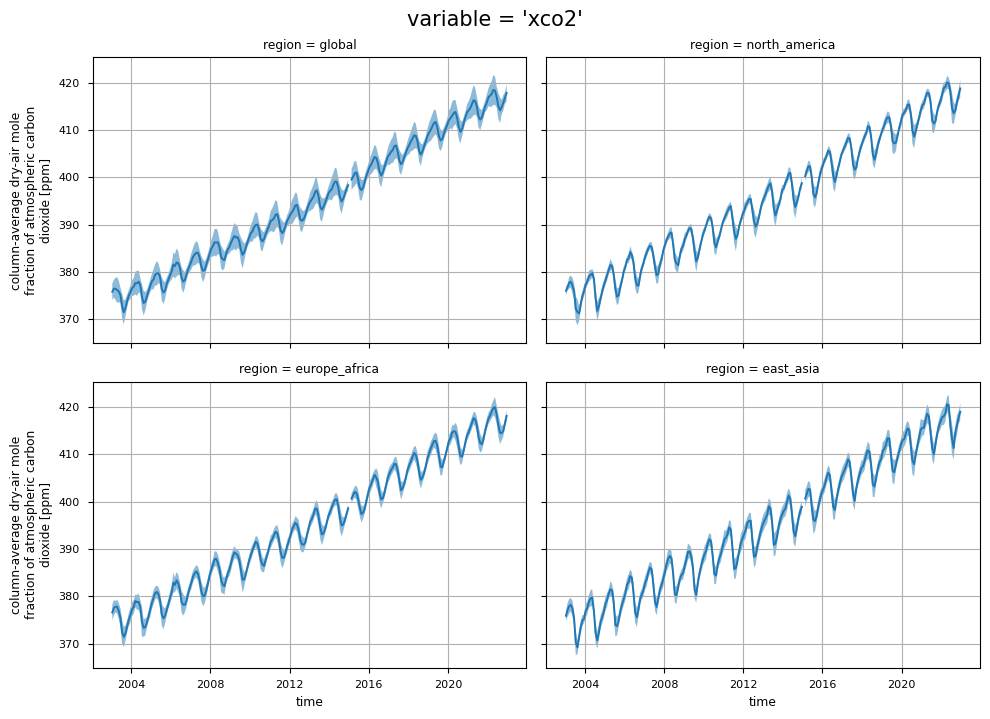

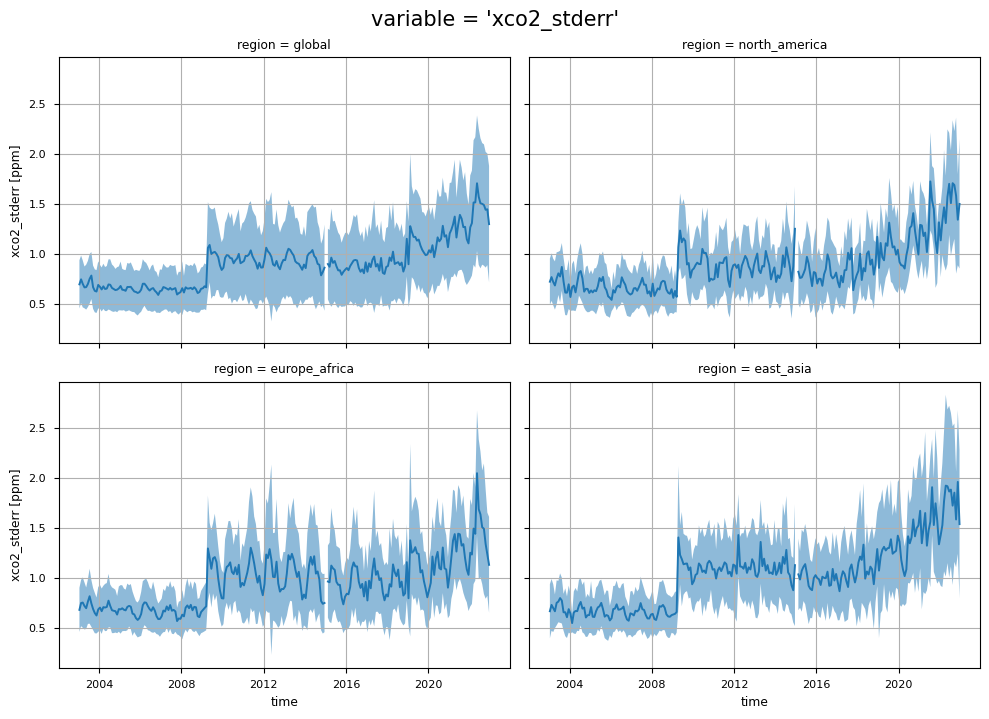

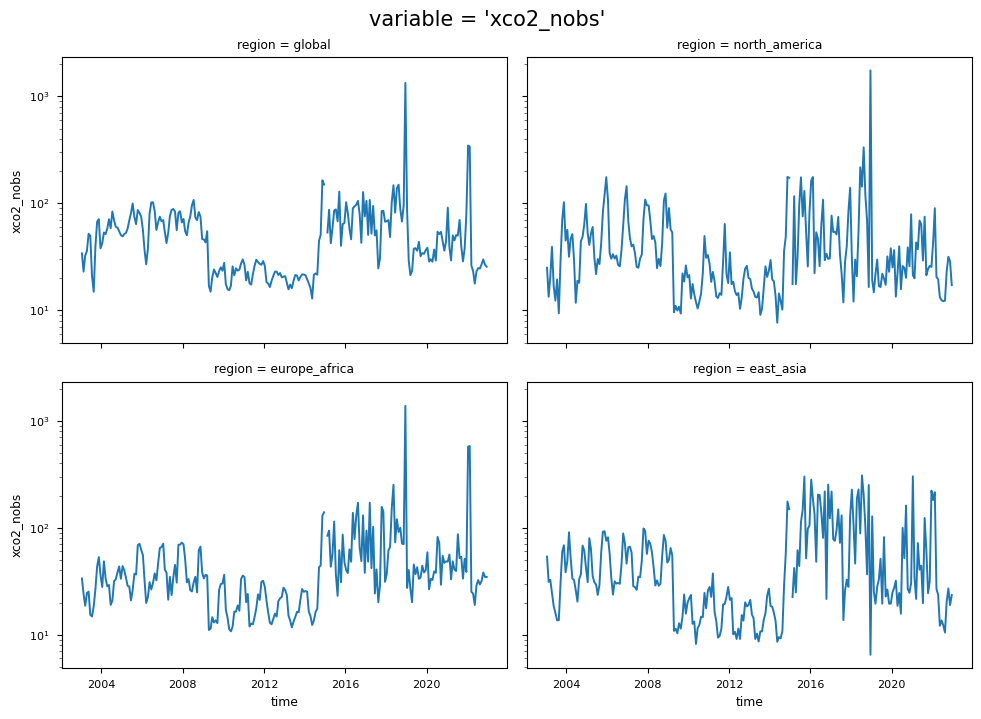

In [10]:
for variable in ["xco2", "xco2_stderr","xco2_nobs"]:
    means = []
    stds = []
    for region, ds in datasets_ts.items():
        da = ds[variable]
        means.append(diagnostics.spatial_weighted_mean(da).expand_dims(region=[region]))
        stds.append(diagnostics.spatial_weighted_std(da).expand_dims(region=[region]))
    da_mean = xr.concat(means, "region")
    da_std = xr.concat(stds, "region")

    facet = da_mean.plot(col="region", col_wrap=2, figsize=(10, 7))
    for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
        if variable == "xco2_nobs":
            lower = 0
        else:
            lower = da_mean.sel(sel_dict) - da_std.sel(sel_dict)
            ax.fill_between(
            da["time"],
            lower.where(lower > 0, 0),
            da_mean.sel(sel_dict) + da_std.sel(sel_dict),
            alpha=0.5,
        )
        
        # If variaable is xco2_nobs, use log scale for y-axis
        if variable == "xco2_nobs":
            ax.set_yscale("log")
            #ax.set_ylabel("n observations")
            # Imposta tick logaritmici automatici
            from matplotlib.ticker import LogLocator, NullFormatter
            ax.yaxis.set_major_locator(LogLocator(base=10))
            ax.yaxis.set_minor_locator(LogLocator(base=10, subs="all"))
            ax.yaxis.set_minor_formatter(NullFormatter())
        else:
            ax.grid()
    facet.fig.suptitle(f"{variable = }", y=1.02, fontsize=15)
    plt.show()

*The figure shows the monthly time series of XCO$_2$ (top panels) and their associated uncertainties (middle panels) for the entire dataset, including global and regional analyses. The blue lines represent the monthly spatial average, while the shaded areas indicate $\pm$1 standard deviation. The bottom panels shows the time series of monthly spatial average of the  number of individual XCO$_2$ Level 2 observations used to compute Obs4MIPs (Level 3) data. The main titles indicate the variable shown, while the subtitles specify the corresponding regions.*

## ℹ️ If you want to know more

### Key resources

The CDS catalogue entries for the data used were:
* Carbon dioxide data from 2002 to present derived from satellite observations: https://cds.climate.copernicus.eu/datasets/satellite-carbon-dioxide?tab=overview

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

Users interested in the investigation of CO$_2$ fluxes can consider to use specifically designed Copernicus resources like [CAMS global inversion-optimised greenhouse gas fluxes and concentrations](https://ads.atmosphere.copernicus.eu/datasets/cams-global-greenhouse-gas-inversion?tab=overview).

### References
[[1]](https://library.wmo.int/idurl/4/69057) World Meteorological Organization. (2024). WMO Greenhouse Gas Bulletin, 20, ISSN 2078-0796.

[[2]](https://doi.org/10.5194/essd-17-965-2025) Friedlingstein, P., O'Sullivan, M., Jones, M. W., Andrew, R. M., Hauck, J., Landschützer, P., Le Quéré, C., Li, H., Luijkx, I. T., Olsen, A., Peters, G. P., Peters, W., Pongratz, J., Schwingshackl, C., Sitch, S., Canadell, J. G., Ciais, P., Jackson, R. B., Alin, S. R., Arneth, A., Arora, V., Bates, N. R., Becker, M., Bellouin, N., Berghoff, C. F., Bittig, H. C., Bopp, L., Cadule, P., Campbell, K., Chamberlain, M. A., Chandra, N., Chevallier, F., Chini, L. P., Colligan, T., Decayeux, J., Djeutchouang, L. M., Dou, X., Duran Rojas, C., Enyo, K., Evans, W., Fay, A. R., Feely, R. A., Ford, D. J., Foster, A., Gasser, T., Gehlen, M., Gkritzalis, T., Grassi, G., Gregor, L., Gruber, N., Gürses, Ö., Harris, I., Hefner, M., Heinke, J., Hurtt, G. C., Iida, Y., Ilyina, T., Jacobson, A. R., Jain, A. K., Jarníková, T., Jersild, A., Jiang, F., Jin, Z., Kato, E., Keeling, R. F., Klein Goldewijk, K., Knauer, J., Korsbakken, J. I., Lan, X., Lauvset, S. K., Lefèvre, N., Liu, Z., Liu, J., Ma, L., Maksyutov, S., Marland, G., Mayot, N., McGuire, P. C., Metzl, N., Monacci, N. M., Morgan, E. J., Nakaoka, S.-I., Neill, C., Niwa, Y., Nützel, T., Olivier, L., Ono, T., Palmer, P. I., Pierrot, D., Qin, Z., Resplandy, L., Roobaert, A., Rosan, T. M., Rödenbeck, C., Schwinger, J., Smallman, T. L., Smith, S. M., Sospedra-Alfonso, R., Steinhoff, T., Sun, Q., Sutton, A. J., Séférian, R., Takao, S., Tatebe, H., Tian, H., Tilbrook, B., Torres, O., Tourigny, E., Tsujino, H., Tubiello, F., van der Werf, G., Wanninkhof, R., Wang, X., Yang, D., Yang, X., Yu, Z., Yuan, W., Yue, X., Zaehle, S., Zeng, N., and Zeng, J. (2025). Global Carbon Budget 2024, Earth System Science Data, 17, 965-1039.

[[3]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf) Buchwitz, M. (2024). Product User Guide and Specification (PUGS) – Main document for Greenhouse Gas (GHG: CO$_2$ & CH$_4$) data set CDR7 (01.2003-12.2022), C3S project 2021/C3S2_312a_Lot2_DLR/SC1, v7.3.

[[4]](https://doi.org/10.5194/bg-17-6115-2020) Gier, B. K., Buchwitz, M., Reuter, M., Cox, P. M., Friedlingstein, P., and Eyring, V. (2020). Spatially resolved evaluation of Earth system models with satellite column-averaged CO$_2$, Biogeosciences, 17, 6115–6144.

[[5]](https://doi.org/10.1016/j.envint.2023.108057) Zhang, L., Li, T., Wu, J., and Yang, H. (2023). Global estimates of gap-free and fine-scale CO$_2$ concentrations during 2014-2020 from satellite and reanalysis data, Environment International, 178, 108057.

[[6]](https://amt.copernicus.org/articles/13/789/2020/) Reuter, M., Buchwitz, M., Schneising, O., Noël, S., Bovensmann, H., Burrows, J. P., Boesch, H., Di Noia, A., Anand, J., Parker, R. J., Somkuti, P., Wu, L., Hasekamp, O. P., Aben, I., Kuze, A., Suto, H., Shiomi, K., Yoshida, Y., Morino, I., Crisp, D., O'Dell, C. W., Notholt, J., Petri, C., Warneke, T., Velazco, V. A., Deutscher, N. M., Griffith, D. W. T., Kivi, R., Pollard, D. F., Hase, F., Sussmann, R., Té, Y. V., Strong, K., Roche, S., Sha, M. K., De Mazière, M., Feist, D. G., Iraci, L. T., Roehl, C. M., Retscher, C., and Schepers, D. (2020). Ensemble-based satellite-derived carbon dioxide and methane column-averaged dry-air mole fraction data sets (2003–2018) for carbon and climate applications, Atmospheric Measurement Techniques, 13, 789–819.

[[7]](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_D_latest.pdf) Reuter, M., and Buchwitz, M. (2024). Algorithm Theoretical Basis Document (ATBD) – ANNEX D for products XCO2_EMMA, XCH4_EMMA, XCO2_OBS4MIPS, XCH4_OBS4MIPS (v4.5, CDR7, 2003-2022), C3S project 2021/C3S2_312a_Lot2_DLR/SC1, v7.1b.